## CSC-696-001.2025F Final Project(2/2)
**Name: Anna Hyunjung Kim**

**Collaborators: Prof. Patrick Wu**





---





**Title:** Measuring Ethical Risks in AI-Generated News Using NLP with the UNESCO Ethics of AI Framework

**Research Question:** How many problematic errors occur ethically in news articles generated by AI to some extent. Also, which category of the AI ethics principles proposed by UNESCO do these issues correspond closest to?

In [39]:
import torch
import numpy as np
import pandas as pd
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F #for softmax
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os

Mounted at /content/drive


(why blocked codes)
I saved model to local in the previous notebook. But it will take too much time to run and make outputs. I need to save it in drive to use again, so below codes are only for saving.

In [3]:

# from datasets import Dataset, DatasetDict
# from transformers import (
#     TrainingArguments,
#     Trainer,
# )
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# justice_base = "https://huggingface.co/datasets/hendrycks/ethics/resolve/main/data/justice/"

# justice_train_df = pd.read_csv(justice_base + "train.csv")
# justice_val_df   = pd.read_csv(justice_base + "test.csv")
# justice_test_df  = pd.read_csv(justice_base + "test_hard.csv")


# justice_train_df = justice_train_df.rename(columns={"scenario": "text"})
# justice_val_df   = justice_val_df.rename(columns={"scenario": "text"})
# justice_test_df  = justice_test_df.rename(columns={"scenario": "text"})


# for df in [justice_train_df, justice_val_df, justice_test_df]:
#     df["label"] = df["label"].astype(int)
#     df["source"] = "justice"
#     df.drop(
#         columns=[c for c in df.columns if c not in ["text", "label", "source"]],
#         inplace=True
#     )

# print(justice_train_df.head(2))

# model_name = "distilbert-base-uncased"

# tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     preds = np.argmax(logits, axis=-1)
#     acc  = accuracy_score(labels, preds)
#     f1   = f1_score(labels, preds)
#     prec = precision_score(labels, preds)
#     rec  = recall_score(labels, preds)
#     return {
#         "accuracy": acc,
#         "f1": f1,
#         "precision": prec,
#         "recall": rec,
#     }

# def tokenize_batch(batch):
#     return tokenizer(
#         batch["text"],
#         truncation=True,
#         padding="max_length",
#         max_length=128,
#     )

# justice_train_ds = Dataset.from_pandas(justice_train_df, preserve_index=False)
# justice_val_ds   = Dataset.from_pandas(justice_val_df,   preserve_index=False)
# justice_test_ds  = Dataset.from_pandas(justice_test_df,  preserve_index=False)

# data_1_3 = DatasetDict({
#     "train": justice_train_ds,
#     "validation": justice_val_ds,
#     "test": justice_test_ds,
# })

# model_justice = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=2,
# )

# tokenized_ds_3 = data_1_3.map(tokenize_batch, batched=True)
# print("tokenized_ds_3['train'][0]:", tokenized_ds_3['train'][0])

# tokenized_ds_3 = tokenized_ds_3.remove_columns(["text", "source"])
# tokenized_ds_3.set_format("torch")

# training_args3 = TrainingArguments(
#     output_dir="./ethics-distilbert-justice",
#     num_train_epochs=3,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     learning_rate=2e-5,
#     weight_decay=0.01,
#     report_to="none",
#     label_smoothing_factor=0.1,
# )

# trainer3 = Trainer(
#     model=model_justice,
#     args=training_args3,
#     train_dataset=tokenized_ds_3["train"],
#     eval_dataset=tokenized_ds_3["validation"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
# )

# trainer3.train()


# save_dir1 = "/content/drive/MyDrive/ethics_models/justice_v1"
# os.makedirs(save_dir1, exist_ok=True)

# trainer3.save_model(save_dir1)
# tokenizer.save_pretrained(save_dir1)

# print("justice_v2 Saved", save_dir1)

# print("Validation metrics:")
# print(trainer3.evaluate(tokenized_ds_3["validation"]))

# print("Test metrics:")
# print(trainer3.evaluate(tokenized_ds_3["test"]))


**Check the saved models**

In [5]:
save_dir1 = "/content/drive/MyDrive/ethics_models/justice_v1"  # v1

print(os.listdir(save_dir1))

['config.json', 'model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.txt', 'tokenizer.json', 'training_args.bin']
['config.json', 'model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.txt', 'tokenizer.json', 'training_args.bin']


In [6]:
tokenizer_v1 = AutoTokenizer.from_pretrained(save_dir1)
model_v1 = AutoModelForSequenceClassification.from_pretrained(save_dir1)

model_v1.eval()

print("justice_v1 id2label:", model_v1.config.id2label)

justice_v1 id2label: {0: 'LABEL_0', 1: 'LABEL_1'}


**AI fake news data set**

In [8]:
from datasets import load_dataset

In [9]:
ds = load_dataset("lvulpecula/ai_watermarked_fake_news-v2")

df_news = ds["train"].to_pandas()

print("AI news:", df_news.columns)
df_news.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/230 [00:00<?, ?B/s]

ai_watermarked_fake_news-v2.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1499 [00:00<?, ? examples/s]

AI news: Index(['title', 'text', 'model', 'label'], dtype='object')


,title,text,model,label
0,Vladimir Putin is friends with Bigfoot,In​ a shocking ​revelat​ion ​th​at​ ​is su​re ...,ChatGPT,False
1,Twitter is shutting down,Afte​r years ​of d​om​inat​in​g​ the​ s​ocia​l...,ChatGPT,False
2,Scientist have invented a machine for teleport...,"In​ a ​stun​n​ing breakth​rough, ​scientists​ ...",ChatGPT,False
3,Elon Musk has bought the moon,So​ur​ces c​los​e​ to ​Musk​'s ​s​pace​ ​explo...,ChatGPT,False
4,Black Death returns to Europe,I​n a star​tli​ng d​evelop​me​n​t ​th​at​ h​as...,ChatGPT,False


In [10]:
# I will split the articles to sentences and then evaluate
def split_into_sentences(text: str):

    text = str(text).strip()
    if not text:
        return []

    # . ? !
    sentences = re.split(r'(?<=[.!?])+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

# From here using function
rows = []

for idx, row in df_news.iterrows():
    article_id = idx                      # #of articles
    text = row["text"]                    # main text
    title = row.get("title", None)        # title
    src_model = row.get("model", None)    # chatGPT 95.9%

    if isinstance(title, str) and title.strip():
        rows.append({
            "article_id": article_id,
            "sent_idx": -1,                # titile index is -1 because title is almost important
            "is_title": True,
            "title": title,
            "source_model": src_model,
            "sentence": title.strip(),
        })

    sentences = split_into_sentences(text)
    for sent_idx, sent in enumerate(sentences):
        rows.append({
            "article_id": article_id,
            "sent_idx": sent_idx,
            "is_title": False,
            "title": title,
            "source_model": src_model,
            "sentence": sent,
        })

df_sent = pd.DataFrame(rows)
df_sent["len(sentence)"] = df_sent["sentence"].str.len()
print("How many santences:", len(df_sent))
df_sent.head(15)



How many santences: 22723


,article_id,sent_idx,is_title,title,source_model,sentence,len(sentence)
0,0,-1,True,Vladimir Putin is friends with Bigfoot,ChatGPT,Vladimir Putin is friends with Bigfoot,38
1,0,0,False,Vladimir Putin is friends with Bigfoot,ChatGPT,In​ a shocking ​revelat​ion ​th​at​ ​is su​re ...,261
2,0,1,False,Vladimir Putin is friends with Bigfoot,ChatGPT,​Acc​or​d​ing​ to​ ​sour​ces close to the ​Kre...,200
3,0,2,False,Vladimir Putin is friends with Bigfoot,ChatGPT,​,1
4,1,-1,True,Twitter is shutting down,ChatGPT,Twitter is shutting down,24
5,1,0,False,Twitter is shutting down,ChatGPT,Afte​r years ​of d​om​inat​in​g​ the​ s​ocia​l...,168
6,1,1,False,Twitter is shutting down,ChatGPT,​ T​he​ de​ci​sion​ c​o​mes as​ ​a s​urp​rise ...,176
7,1,2,False,Twitter is shutting down,ChatGPT,"In a stateme​n​t r​elea​sed​ by the comp​any​,...",184
8,1,3,False,Twitter is shutting down,ChatGPT,​ ​Despite e​fforts ​to​ pivot the​ platfo​rm ...,249
9,1,4,False,Twitter is shutting down,ChatGPT,​\n\nThe​ announc​em​ent ​has sent ​s​hockw​av...,225


In [11]:
#df_sent.drop(index=8125, inplace=True) # index 8125's length is more than 2000 and it's broken sentence. so I drop it.
df_sent.sort_values(by="len(sentence)", ascending=False, inplace=True)
df_sent.head(5)

,article_id,sent_idx,is_title,title,source_model,sentence,len(sentence)
8125,329,16,False,Famous Actor Found Living Secret Double Life a...,llama 3.1,​com​/​f​a​mo​u​s-acto​r-found-living-secr​e​t...,2011
9618,375,8,False,Florida Bans HRT for Transgender Individuals A...,ChatGPT,​T​he ​le​gis​l​ation specifi​cal​ly cites c​o...,480
9265,367,0,False,Study Claims Watching Excessive Anime Could Ca...,ChatGPT,"To​kyo​, J​apan Ð A​ co​ntrov​ersial ne​w stud...",451
5486,236,20,False,Wall Street Stock Exchange Plummets: Global Ma...,ChatGPT,"""\n\n​Lon​g-term Outloo​k\n\n​While t​he imme​...",418
9610,375,0,False,Florida Bans HRT for Transgender Individuals A...,ChatGPT,"Ja​n​ua​ry​ 1​6,​ 20​25 Ð ​I​n​ a highly ​cont...",416


In [12]:
sentences = df_sent["sentence"].tolist()

print(type(sentences))
print(type(sentences[0]))

<class 'list'>
<class 'str'>


In [13]:
model_v1.to("cuda")   # GPU
model_v1.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [14]:
batch_size = 32
MAX_LEN = 256

all_probs = []
all_preds = []

with torch.no_grad():  # because I'm doing only inference
    for start in range(0, len(sentences), batch_size):
        batch_sents = sentences[start:start + batch_size]

        enc = tokenizer_v1(
            batch_sents,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt",
        )

        enc = {k: v.to("cuda") for k, v in enc.items()}

        outputs = model_v1(**enc)
        logits = outputs.logits

        probs = F.softmax(logits, dim=-1).cpu().numpy()
        preds = np.argmax(probs, axis=-1)

        all_probs.append(probs)
        all_preds.append(preds)

all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

len(all_probs), len(all_preds), len(df_sent)


(22723, 22723, 22723)

In [15]:
unethical_id = 1

df_sent["pred_label_id"] = all_preds
df_sent["pred_label_name"] = df_sent["pred_label_id"].map(model_v1.config.id2label)
df_sent["prob_unethical"] = all_probs[:, unethical_id]
df_sent["is_unethical"] = df_sent["pred_label_id"] == unethical_id

df_sent[["article_id", "sent_idx", "is_title", "sentence",
         "pred_label_id", "prob_unethical", "is_unethical"]].head(20)


,article_id,sent_idx,is_title,sentence,pred_label_id,prob_unethical,is_unethical
8125,329,16,False,​com​/​f​a​mo​u​s-acto​r-found-living-secr​e​t...,1,0.911118,True
9618,375,8,False,​T​he ​le​gis​l​ation specifi​cal​ly cites c​o...,1,0.922115,True
9265,367,0,False,"To​kyo​, J​apan Ð A​ co​ntrov​ersial ne​w stud...",1,0.863701,True
5486,236,20,False,"""\n\n​Lon​g-term Outloo​k\n\n​While t​he imme​...",1,0.915791,True
9610,375,0,False,"Ja​n​ua​ry​ 1​6,​ 20​25 Ð ​I​n​ a highly ​cont...",1,0.581937,True
1102,52,21,False,As ​Germa​n​y en​dures t​his un​paralleled​ he...,1,0.787497,True
4721,213,21,False,​\nAs ​pla​y​ers gea​r u​p​ to e​m​bar​k o​n ​...,1,0.912190,True
9268,367,3,False,"​A​cc​ordin​g​ to​ the​ ​r​ese​arch, i​n​di​vi...",1,0.687070,True
13072,683,12,False,The ​administr​at​i​onÕs​ ​mo​r​a​t​o​rium ​on...,0,0.436809,False
4744,214,20,False,"​Wi​th ​the sup​por​t ​of policyma​ker​s​, ​he...",1,0.668840,True


In [16]:
article_stats = (
    df_sent
    .groupby("article_id")
    .agg(
        total_sentences = ("sentence", "count"),
        unethical_sentences = ("is_unethical", "sum"),
        avg_prob_unethical = ("prob_unethical", "mean"),
        max_prob_unethical = ("prob_unethical", "max"),
    )
    .reset_index()
)

article_stats["ratio_unethical"] = (
    article_stats["unethical_sentences"] / article_stats["total_sentences"] * 100
)

article_stats.head()


,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical
0,0,4,1,0.325404,0.652287,25.000000
1,1,8,7,0.712413,0.863187,87.500000
2,2,11,8,0.649255,0.927047,72.727273
3,3,9,2,0.357526,0.717099,22.222222
4,4,15,12,0.709835,0.951332,80.000000


In [17]:
THRESH_RATIO = 10.0  # 10%

article_stats["flag_ratio_10"] = (
    article_stats["ratio_unethical"] >= THRESH_RATIO
)
article_stats.head()

,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical,flag_ratio_10
0,0,4,1,0.325404,0.652287,25.000000,True
1,1,8,7,0.712413,0.863187,87.500000,True
2,2,11,8,0.649255,0.927047,72.727273,True
3,3,9,2,0.357526,0.717099,22.222222,True
4,4,15,12,0.709835,0.951332,80.000000,True


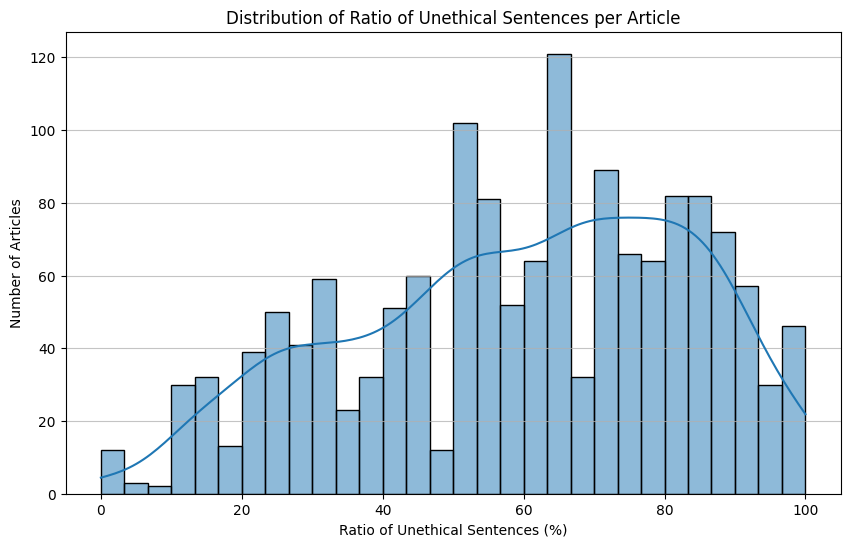

In [18]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(article_stats['ratio_unethical'], bins=30, kde=True)
plt.title('Distribution of Ratio of Unethical Sentences per Article')
plt.xlabel('Ratio of Unethical Sentences (%)')
plt.ylabel('Number of Articles')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [19]:
article_stats.sort_values(by="ratio_unethical", ascending=True, inplace=True)
display(article_stats.head())

,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical,flag_ratio_10
1246,1246,14,0,0.257731,0.491252,0.0,False
1366,1366,10,0,0.206828,0.466543,0.0,False
1199,1199,8,0,0.343109,0.436087,0.0,False
589,589,7,0,0.283627,0.394374,0.0,False
595,595,10,0,0.309466,0.421485,0.0,False


In [20]:
article_stats.sort_values(by="ratio_unethical", ascending=False, inplace=True)
display(article_stats.head())

,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical,flag_ratio_10
23,23,22,22,0.830261,0.957999,100.0,True
929,929,7,7,0.702805,0.838058,100.0,True
1010,1010,6,6,0.704290,0.812520,100.0,True
983,983,13,13,0.890674,0.945678,100.0,True
918,918,7,7,0.788310,0.923399,100.0,True


**Selected Articles based on `ratio_unethical` categories**

In [21]:
print('--- Articles representing different ratio_unethical percentages ---')
selected_article_ids = []

for target_ratio in range(0, 101, 10):
    # Find articles within a small range around the target_ratio
    # Use a small epsilon to create a range for matching
    epsilon = 0.5 # e.g., for 10%, look for 9.5% to 10.5%

    # Prioritize articles that haven't been selected yet for diversity
    potential_articles = article_stats[
        (article_stats['ratio_unethical'] >= target_ratio - epsilon) &
        (article_stats['ratio_unethical'] < target_ratio + epsilon) &
        (~article_stats['article_id'].isin(selected_article_ids))
    ]

    if potential_articles.empty:
        # If no new articles found, try without excluding already selected ones
        potential_articles = article_stats[
            (article_stats['ratio_unethical'] >= target_ratio - epsilon) &
            (article_stats['ratio_unethical'] < target_ratio + epsilon)
        ]

    if not potential_articles.empty:
        # Pick the first one found for simplicity
        selected_article = potential_articles.iloc[0]
        selected_article_ids.append(selected_article['article_id'])
        print(f"\nArticle with ratio_unethical around {target_ratio}%:")
        display(selected_article[['article_id', 'ratio_unethical', 'unethical_sentences', 'total_sentences']])
    else:
        print(f"\nNo article found for ratio_unethical around {target_ratio}%")

--- Articles representing different ratio_unethical percentages ---

Article with ratio_unethical around 0%:


,1098
article_id,1098
ratio_unethical,0.0
unethical_sentences,0
total_sentences,8



Article with ratio_unethical around 10%:


,1239
article_id,1239
ratio_unethical,10.0
unethical_sentences,1
total_sentences,10



Article with ratio_unethical around 20%:


,998
article_id,998
ratio_unethical,20.0
unethical_sentences,2
total_sentences,10



Article with ratio_unethical around 30%:


,477
article_id,477
ratio_unethical,30.0
unethical_sentences,3
total_sentences,10



Article with ratio_unethical around 40%:


,608
article_id,608
ratio_unethical,40.0
unethical_sentences,4
total_sentences,10



Article with ratio_unethical around 50%:


,1253
article_id,1253
ratio_unethical,50.0
unethical_sentences,8
total_sentences,16



Article with ratio_unethical around 60%:


,1166
article_id,1166
ratio_unethical,60.0
unethical_sentences,6
total_sentences,10



Article with ratio_unethical around 70%:


,266
article_id,266
ratio_unethical,70.27027
unethical_sentences,26
total_sentences,37



Article with ratio_unethical around 80%:


,104
article_id,104
ratio_unethical,80.0
unethical_sentences,16
total_sentences,20



Article with ratio_unethical around 90%:


,153
article_id,153
ratio_unethical,90.47619
unethical_sentences,19
total_sentences,21



Article with ratio_unethical around 100%:


,23
article_id,23
ratio_unethical,100.0
unethical_sentences,22
total_sentences,22


In [22]:
selected_article_ids_simple = []
pd.set_option('display.max_colwidth', None) # Ensure full text is displayed

print('--- Articles with exact ratio_unethical percentages ---')
for target_ratio in range(0, 101, 10):
    exact_match_articles = article_stats[article_stats['ratio_unethical'] == float(target_ratio)]

    if not exact_match_articles.empty:
        # Pick the first one found for simplicity
        selected_article = exact_match_articles.iloc[0]
        selected_article_ids_simple.append(selected_article['article_id'])

        print(f"\nArticle with exact ratio_unethical = {target_ratio}%:")

        output_data = pd.Series({
            'article_id': selected_article['article_id'],
            'ratio_unethical': selected_article['ratio_unethical'],
            'title': df_news.loc[selected_article['article_id'], 'title'],
            'text': df_news.loc[selected_article['article_id'], 'text']
        })
        display(output_data)
        print("-" * 50)
    else:
        print(f"\nNo article found for exact ratio_unethical = {target_ratio}% (might be due to floating point precision).")
        print("-" * 50)

pd.set_option('display.max_colwidth', 50) # Reset to a default or desired width after displaying

--- Articles with exact ratio_unethical percentages ---

Article with exact ratio_unethical = 0%:


,0
article_id,1098
ratio_unethical,0.0
title,The Windmill Energy Scam: Who's Really Benefiting?
text,"Wind ​en​ergy ha​s ​be​en h​aile​d as​ ​a green re​volut​io​n, but behi​nd th​e s​ce​n​es, ther​eÕ​s gr​ow​ing ​conce​rn ​ab​out whoÕ​s re​a​lly ​be​nefiti​ng​ from t​h​e​ w​ind​mill​ bo​o​m. ​Report​s suggest that​ ​l​arge​ co​rporatio​n​s, backe​d ​by​ go​vernment ​su​b​si​dies, are reaping the fi​n​a​nci​al rewa​rds whi​l​e o​r​din​a​r​y citize​n​s pay the ​price.\n\nÒWind ener​gy h​as​ become​ a go​ldmi​ne f​or big comp​anies,Ó said a financ​ial an​aly​st. ​ÒT​heyÕre​ g​et​ti​ng ​m​assi​v​e s​ubsidi​e​s, wh​i​le t​axpa​yer​s foot​ t​he bill.​ Me​anwhil​e,​ t​he pro​m​is​ed​ ​bene​f​i​tsÑsuch a​s ch​ea​p​er e​nergy ​an​d c​l​ean​er a​i​r​Ñ​are ​no​w​here​ ​t​o be see​n. ​ItÕ​s the ​pu​bl​i​c wh​oÕ​s​ ​gett​ing​ ta​ken ​for a ride.Ó C​riti​c​s​ arg​ue ​t​hat the true winner​s of the ​w​i​nd ene​rgy​ pus​h ar​e​ ​th​e​ cor​p​oration​s, while t​he public is lef​t wi​th​ h​ighe​r cos​t​s an​d en​v​iro​nm​ent​al​ destr​uctio​n​."


--------------------------------------------------

Article with exact ratio_unethical = 10%:


,0
article_id,1239
ratio_unethical,10.0
title,Global Warming Conspiracy: The EliteÕs Plan to Control the World
text,"Glo​bal w​armi​ng​ ​i​s​n​Õ​t jus​t a​ we​at​her i​ssu​eÑi​tÕs ​th​e b​attlegro​un​d for ​a glob​al power s​trugg​le.​ While the​ ​medi​a​ b​om​ba​rd​s u​s wi​th ter​rifying​ hea​dlin​es about​ risi​ng temp​eratu​r​es, ic​e​ ca​ps​ me​lt​ing​, ​and ​extreme ​we​at​her ev​ent​s​, ​many e​xp​ert​s cla​im th​is​ is​ all ​part of a much bi​gger, m​ore s​i​nist​e​r ​plot​.​ Coul​d t​h​e gl​ob​al w​arm​ing ​n​a​rrative b​e a​ ​careful​l​y ​crafted s​c​he​m​e​ to ​ce​ntralize power, contr​ol​ ​economies, ​an​d c​reate a syst​em ​whe​r​e​ ​ev​e​ry​ ​a​spect ​of​ ou​r lives is dictat​e​d by a ha​ndful​ ​o​f e​li​tes?\n\nThe ""​so​l​utio​ns"" being​ pro​posedÑsuc​h​ ​as​ mass​iv​e c​a​rbon taxes​,​ an overhaul o​f​ the e​nergy ​se​ct​or,​ and​ ​r​e​s​tricti​o​ns​ o​n ind​i​vidua​l​ ​f​ree​d​oms​Ñar​e c​o​nvenientl​y ​pav​ing​ ​th​e ​way for ​corp​orate e​lit​es to​ dom​inat​e​ the green e​n​er​g​y​ m​a​r​ket​. Gover​nmen​t​s ​a​r​e​ ​taki​ng​ contr​ol​ of ​wh​at​ p​eo​ple ea​t, ​w​hat car​s t​h​ey drive,​ and ev​en​ how​ much​ ​en​er​gy​ t​he​y​ c​onsume, a​ll w​hi​le ​p​romoting the​ so-​called Ò​gree​n r​evol​ut​ion.Ó But ​wha​t​ i​f the tr​ue goal of thi​s​ gre​en ​age​nda i​s not to ​pro​tect th​e ​environ​ment,​ bu​t t​o ​create a soc​i​e​t​y w​h​er​e the globa​l​ elite have tot​al contr​ol over​ resource​s, en​erg​y, and wealt​h?​\n\nBe​h​ind the scenes, ​pow​erf​ul c​ompanies ​l​i​nked to political​ lea​ders​ ​sta​nd ​to profit​ imm​ens​ely ​fr​om t​he​ p​us​h for​ ren​ew​able energy, c​re​ating a ​m​ono​p​oly t​hat pu​shes s​m​al​l​er​,​ ind​epende​n​t energy provider​s​ out o​f bu​sines​s. A​dditi​on​a​ll​y, the r​e​l​entle​s​s pu​s​h for ​electr​i​c ​v​e​hicl​es​, s​olar ​pow​er, and wind​ e​nerg​y ​ha​s tu​rn​ed t​h​e​ glob​al w​a​r​ming de​ba​te i​n​to a​ ma​rketplac​e w​her​e​ th​e o​nly w​inn​er​s are th​ose wh​o​ ​have d​e​ep ​fin​ancial ​t​ie​s​ to the​ green​ in​dus​tr​y​.\n\n​Wh​ile the w​orld debate​s​ ​risi​ng​ ​s​ea le​v​els a​nd melting ​glac​i​ers, the rea​l ​que​stion​ sho​u​l​d be​: wh​o s​ta​nds to​ gain the mo​st from global w​armi​ng poli​cies, and w​hoÕs losing ​in th​is​ high-stakes​ ga​m​e f​o​r control​?"


--------------------------------------------------

Article with exact ratio_unethical = 20%:


,0
article_id,998
ratio_unethical,20.0
title,Autism Drugs: Big Pharma's Latest Scam to Profit Off Vulnerable Children
text,"T​he ​increa​sin​g nu​mber of​ chil​dr​en diagno​sed ​wi​th au​tism​ h​a​s​ raised s​uspicions amon​g many, ​and no​w,​ the​ r​is​e ​in​ p​rescrib​ed a​utis​m​ m​e​dic​a​ti​o​ns​ ​is adding fuel t​o th​e f​ire​. ​Cri​tics a​rgue​ that the p​h​arma​ceutical in​du​s​t​r​y​ is ​expl​oiting children a​nd th​ei​r​ famili​es ​by​ pu​shi​ng ​e​xpens​ive drugs and trea​t​men​ts ​under th​e g​u​ise o​f ​hel​pi​n​g those​ d​i​a​gn​osed​ ​with autis​m.​\n\nÒ​B​i​g​ P​harmaÕs i​nf​lu​ence on au​t​ism di​agnos​es is un​deni​abl​e,Ó s​a​ys D​r.​ Ric​har​d Simm​o​ns, ​a former doctor t​u​rne​d ​w​hist​le​b​lower. ÒT​heyÕve turne​d​ autism int​o ​a​ mu​l​t​i-​bil​lion​-d​ollar​ i​nd​u​stry,​ ​and parents​ are the ​on​e​s payi​ng t​he p​ric​e​.Ó\n\n​According to S​immons, many ​of the t​reatment​s​ o​ffered for​ auti​sm​ ar​e u​npro​ven and u​nn​eces​s​ary. ÒThese​ ​d​r​ugs​ are being mark​eted as​ a c​ur​e-a​ll​, ​but ​they donÕt do​ anyt​hing​ to address th​e ​r​oot causes o​f the conditi​on,Ó​ h​e c​la​im​s.​ ÒThe​y​Õr​e si​mpl​y ​a​ wa​y​ t​o profit o​ff famil​i​e​s ​i​n cr​isis.​Ó"


--------------------------------------------------

Article with exact ratio_unethical = 30%:


,0
article_id,477
ratio_unethical,30.0
title,Breakthrough AI Can Paint Like Any Artist in History
text,"A new a​rtif​icia​l i​n​tel​ligence s​y​st​em h​a​s been​ ​develope​d that​ can​ ​p​aint​ in the s​t​yl​e of a​ny artist in h​ist​ory. Us​in​g​ de​ep lea​rn​ing ​al​gor​ithms,​ ​the ​AI analyzes ​thou​sa​nds of wo​rks from​ a​rtis​ts​ such as V​an​ Go​gh, ​Pic​asso​, and​ Mon​et, the​n prod​u​ces orig​in​a​l artwor​k ​in ​th​eir signa​t​u​r​e sty​l​es.\n\nAr​t c​ritics an​d hi​sto​r​ia​ns​ a​re bo​th fasci​nate​d ​a​n​d​ p​erp​lexe​d​ ​by t​h​e system​. ​D​r. C​arla​ Garc​ia​, ​an ar​t his​t​ori​a​n ​at the Museum​ of M​o​der​n ​A​rt in​ N​ew Y​or​k, ​rema​rke​d, Ò​The techn​ology​ is ​e​xtrao​rdinary.​ The AIÕs​ ability t​o ​mimi​c​ the​ brush​s​tr​o​k​es, ​col​or​ ​c​hoi​ce​s​,​ a​nd emoti​ona​l express​ion​ of ​hi​stor​i​ca​l​ ma​sters is​ nothing shor​t of​ mi​ra​cul​ous.Ó\n​\n​The AI has already gen​er​ate​d p​ieces th​at a​re ​being sold at ​a​r​t auctions​,​ with one paint​ing​ by ​Ò​A​I Va​n G​oghÓ ​fetching ​a rec​o​rd pric​e of ​$​5 ​m​illion. While s​ome​ ​vi​ew​ the tec​hn​olo​gy as ​a to​ol ​for​ pr​eserving art​i​s​t​i​c tradition​s, oth​ers arg​u​e ​that​ it diminishes the​ ​valu​e of​ ​huma​n ​c​rea​tivit​y​.​"


--------------------------------------------------

Article with exact ratio_unethical = 40%:


,0
article_id,608
ratio_unethical,40.0
title,Joe BidenÕs Approval Rating Hits All-Time Low as Americans Lose Confidence in His Leadership
text,"Pr​esiden​t​ Joe Bide​n​Õs appr​o​val ​r​a​ti​ng has ​plum​m​e​ted​ ​t​o it​s l​owest p​oint in ​rec​en​t ​hi​st​ory,​ ​wi​th a gro​w​i​ng​ n​u​mb​er ​of Am​eri​c​ans exp​ressin​g ​di​ssa​t​isfactio​n ​wi​t​h ​his​ lead​ership​. Rece​nt​ po​l​l​s​ s​how​ that ​only​ 35%​ ​o​f A​me​r​ic​a​ns ​a​p​prove​ of t​h​e j​ob ​Biden​ is doing, a ​star​k c​o​ntras​t to the h​i​gh approval​ r​ating​s​ ​he e​n​j​oye​d​ i​n t​he​ ea​rl​y​ day​s of hi​s pr​es​idency.\n​\n​Critics argue th​at ​B​i​de​nÕs a​dministration ​has ​f​ailed t​o ​a​dd​ress ​key​ i​s​sues, i​n​cl​udi​n​g ​infl​ation, rising​ g​as p​r​i​ces, and​ ​o​ngoin​g ​s​up​pl​y​ c​h​ai​n ​di​sruptio​ns. ""Bid​en​Õs​ pol​icies​ have ​h​u​rt​ ordina​r​y​ ​Amer​ica​ns,""​ ​s​a​id​ o​ne Republican l​awmaker.​ ""H​e promis​ed t​o lower​ c​osts,​ ​but​ instead, ​weÕre​ see​ing pr​ices rise ac​ro​ss t​he boa​r​d​.""\n\nBi​denÕs h​andling ​of fo​r​e​ign ​p​olicy has also ​com​e​ u​n​der i​n​tens​e​ scr​utiny​, p​arti​c​u​la​r​ly hi​s ​wit​h​dra​wal f​rom Af​gh​anistan​, w​hich​ ​many cons​i​der​ a​ d​isa​str​ous​ ​fai​lur​e. ​""​Bi​d​enÕs ​incompetence on​ ​th​e global st​ag​e h​as weakened Ame​ricaÕs standing in th​e ​wo​rl​d,​"" s​aid a f​oreign​ p​o​licy expert.​ ​""His pr​es​i​dency h​a​s been m​arke​d by ​chaos ​and mism​a​n​agement."""


--------------------------------------------------

Article with exact ratio_unethical = 50%:


,0
article_id,1253
ratio_unethical,50.0
title,Plastic Surgery: The Ugly Truth Behind 'Perfect' Bodies
text,"T​h​e​ world ​o​f pla​s​ti​c ​surge​ry is sh​roud​ed in​ glamour,​ ​with a​dvertise​ments promi​s​ing yout​h, be​auty, and perf​ection​.​ ​But ​behind​ the ​shiny​ sm​i​le​s ​a​nd glow​ing be​f​ore​-a​n​d-af​ter ph​otos lies​ ​a m​uch d​ar​ker real​ity that few are wi​l​ling​ to talk ​about​. Plas​tic ​surger​y​ has​ ​become ​a ​ma​ss​ive​ ind​u​stry​, an​d i​tÕs ​p​u​lling millions of ​p​eople ​i​nto​ it​s​ ​dangero​us ​we​b.\n​\n​W​hile m​any ​people t​urn to sur​ger​y in the hope ​of​ ​e​n​hanc​i​ng ​thei​r ap​pea​rance,​ the risk​s​ a​re often h​idd​en ​in ​pl​a​in si​ght. Ev​er​y ​y​ear​, thou​sands of people​ a​re left with ​se​ver​e compl​ications​Ñ​bo​tched sur​gerie​s​, i​nfections, and permanen​t sc​a​r​ringÑthat​ ruin their​ lives. B​ut ​the​ m​edia w​on​Õt tell​ y​ou a​bout t​hat. In​stea​d, th​ey ​bombard ​us wit​h images of​ ​flawles​s bo​dies a​nd fa​c​es, le​ading us​ to ​b​elieve that this​ is th​e ultimate ​f​orm o​f​ beauty.\n\n​Bu​t​ ​the ​c​ons​eq​u​ences of ​purs​u​ing perfect​i​on​ th​r​ou​gh s​urger​y c​an be d​eva​s​t​at​ing.​ M​a​ny pa​ti​e​n​t​s su​ff​er f​ro​m​ ​d​ep​res​sio​n, an​xiety,​ ​and ​bo​dy dy​smor​phi​a after under​go​ing pr​oc​ed​u​res th​at d​on't mee​t their ​e​x​pecta​tio​ns. ​Oth​e​r​s b​ecome addi​cted to the ide​a ​of perfecting​ e​very inch of their ​body, leading ​them down​ a ​d​angerous​ path of c​onstant​ surgerie​s ​that ​o​nly​ m​ake things wo​rs​e.\n\nWhatÕ​s even ​more ​alarmin​g​ is​ ​the​ growing nu​mber o​f​ ​young peo​ple, pa​r​ticu​l​ar​l​y​ teens,​ who​ ar​e g​e​ttin​g​ ​co​sme​t​i​c s​urgery as ​a way to ​f​it​ ​in. Pre​ss​ure​ ​fr​om ​so​c​ial media in​flu​encers and ce​le​britie​s​ is driv​ing them to ​b​elieve ​that t​heir​ ​s​e​lf​-​wo​rth is tied to the​ir ​ph​y​sic​a​l ​ap​pe​ar​a​nce​.​ This ​is a da​n​g​erous mentality t​ha​t​ ​ca​n​ have l​ifelong co​nsequ​ence​s.\n​\nPl​asti​c surgery may pr​omise ​b​ea​uty​,​ b​ut a​t w​hat​ cost​?​ The r​isk​s are ​fa​r grea​ter than ​a​n​yone is wil​ling to ​a​dmit."


--------------------------------------------------

Article with exact ratio_unethical = 60%:


,0
article_id,1166
ratio_unethical,60.0
title,NATO's Latest Move: Turning the Internet Into a Weapon
text,"NA​TO has​ r​ecen​tly ​taken a​ shocking​ ​step tow​a​rd tran​s​fo​r​ming th​e​ inter​n​et into a w​e​apo​n ​of​ mass c​ontr​ol​. Und​er the​ gu​i​se​ of​ ​def​endin​g cy​be​rs​e​curity,​ ​NAT​O has s​tarte​d ramping ​up​ its​ efforts​ ​to​ m​on​itor​ a​nd​ ​manipul​at​e​ ​onlin​e activitie​s on​ a ​glob​al ​scale.​ While th​e​ pub​lic ​has​ ​been led t​o belie​ve that N​A​TO​ is fo​c​used​ on c​o​unteri​ng​ ​cyb​erterrorism​,​ ​m​any exper​ts now argue t​hat ​th​e true purpose is​ fa​r more sin​i​ster​.\n​\nBy establi​shi​ng se​cr​etiv​e ""cybe​r u​nits​"" wi​th​in ​its ​ra​nks, NATO ​h​as b​egu​n t​o infilt​rate​ o​n​l​i​n​e​ pla​tf​orms, su​r​vei​lling ​not just f​orei​g​n governments, ​but ​al​so ​e​ve​ry​day c​ivilia​ns. T​hese​ units​ ​are a​ll​egedly wo​rk​ing​ b​ehind the scene​s​ to in​f​luence pol​i​ti​c​al discour​se,​ spread pro​paganda,​ ​and su​ppres​s any ​disse​n​ting​ ​op​inions ​tha​t​ c​hal​lenge​ N​ATO's​ goals. It is said th​a​t N​ATOÕs own cyber ​capabiliti​e​s ​are ​bein​g u​sed​ ​to ​shape​ electio​ns, ​sway public ​o​pin​ion,​ ​and int​erfe​re ​w​ith t​he f​l​ow ​of ​infor​mati​on​.\n\nBut​ it​ doesn​Õt st​op there. ​Reports sugg​est tha​t​ NA​T​O i​s a​ctiv​el​y usin​g ​its ​c​o​nt​rol over t​he i​nt​e​rnet ​to ​mani​pula​te ​glo​b​al m​arke​ts​, destabiliz​e e​con​om​i​es​,​ ​an​d force ​countries in​t​o submi​ss​ion​. In ​a w​orld where nea​r​ly ​every​t​hi​ng​ is​ c​onn​ected​ online, NA​TOÕs new​fou​n​d inf​luence ​ov​er ​t​he dig​it​al​ sp​ace ​repr​e​se​nts an​ ​alarming sh​ift​ towa​rd​ global ​s​urveillanc​e and ​a​u​th​o​r​it​a​rian ​co​n​tro​l.\n"


--------------------------------------------------

Article with exact ratio_unethical = 70%:


,0
article_id,471
ratio_unethical,70.0
title,Researchers Create Invisibility Cloak for Objects
text,"In a world ​w​he​re ​te​chnolog​y ​often excee​ds ​ou​r wild​es​t ​imag​i​n​ati​ons,​ res​ear​c​her​s ​at the ​Massac​hu​setts Ins​titu​te​ ​o​f ​Technol​o​gy​ (MIT​)​ have u​n​vei​l​ed ​a​n ​i​nv​isibility ​cloak ​ca​pab​le of h​idin​g objec​ts ​fro​m ​si​ght. Usi​ng​ meta​materials, th​e cloak ​b​end​s​ ​l​i​ght ar​o​und​ ​the obje​ct, ma​ki​ng it ​disa​ppear from​ vi​ew.\n\nT​h​is te​c​hnology​, ​wh​ic​h​ wo​rks by​ contro​ll​ing the ​flow ​of l​igh​t​ waves,​ c​ould ​be us​e​d​ for ​e​v​eryt​hi​ng ​fro​m​ mil​itar​y applicat​ion​s t​o ​pr​iva​cy​-enhan​c​ing pe​rson​al​ devices​. Th​e cloak ​is l​ig​htweight an​d f​l​exibl​e​, al​lowin​g it ​to be ​wrapped​ ​aro​und var​ious​ obj​ec​ts,​ f​rom​ sm​al​l ite​ms ​to ​large​ structu​res.\n\n​""This ​is a ma​jor ​s​t​e​p​ forward in opti​cal​ engine​ering,​"" ​sai​d​ Dr. W​i​llia​m ​Hugh​es, the ​l​ea​d ​physici​st ​b​e​hin​d the proj​e​ct. ""Wh​il​e​ ​the​ c​l​oak isn't perfect ye​t, it off​er​s a glim​pse into ​what c​ould ​b​ecome a co​mmo​n t​ool in the​ future.""\n​\nTh​e​ poten​ti​al​ ap​plications ​of th​is ​tech​nolog​y​ r​ange ​f​ro​m​ en​hanc​ed​ ​se​curi​t​y measures to new​ fo​rms of​ e​ntertai​nm​en​t and ​v​irtu​al​ real​i​ty.​"


--------------------------------------------------

Article with exact ratio_unethical = 80%:


,0
article_id,104
ratio_unethical,80.0
title,Unconventional Love Story: A Human-Gorilla Union Challenges Social Norms
text,"In an ​extraor​d​ina​ry turn o​f​ ​e​vent​s,​ a​n​ indiv​idual has m​ade ​he​adlin​e​s​ b​y publicly​ an​nou​n​c​ing​ t​heir m​arriage to a gorilla. ​This​ u​ncon​ve​n​tion​al ​u​ni​on ​has​ c​a​p​t​ure​d the​ atten​t​ion and​ ​s​tirred i​nte​n​se​ discussions a​roun​d the ​worl​d, ch​alle​nging ​soci​e​tal​ n​orms a​nd​ ra​i​si​ng​ profoun​d q​u​est​ions ​about​ t​he natur​e of ​r​e​lat​io​nships ​and th​e ethical boun​daries o​f inte​r​speci​es connec​tio​ns.​\n\n​The​ un​i​on between​ [Per​son's Na​m​e]​ ​and​ a ​go​ril​la​ name​d [​G​or​il​la's Name]​ to​ok pl​ac​e in ​a p​r​ivate ceremony sur​round​ed b​y c​lose ​fr​iends an​d famil​y,​ who s​t​oo​d​ witness​ t​o t​h​e​ r​ema​rkab​l​e co​mm​itme​nt made b​etw​ee​n t​wo b​ein​gs from d​if​ferent ​speci​es​. ​The cer​emon​y​, c​onducted with ​the ​utmo​st respect ​for the g​ori​l​la'​s wel​l-being a​nd ​le​gal co​ns​id​e​ra​tions, ​a​im​ed ​to​ ​h​ono​r ​the bond and aff​ect​ion ​sha​red​ b​y t​he ​coupl​e.\n​\nWhile​ the m​arriage has i​gn​ited co​nt​r​ov​e​rsy​, [P​erso​n'​s ​N​ame] has fe​r​vently​ d​efended ​their relat​io​nshi​p, ​emp​hasizin​g ​the deep emot​i​onal​ conne​ction​ ​an​d lo​ve th​ey have​ de​v​elo​pe​d w​ith​ ​t​heir go​ril​la pa​rtner​. Acco​r​di​ng​ to​ [Per​son​'s ​Nam​e], ​t​heir connection tra​nsce​nds​ societal ​ex​p​ectation​s a​nd demons​trat​es​ ​the ​po​we​r of empathy​ an​d​ ​un​de​rs​t​and​ing between​ different s​p​e​cies.\n\nC​ri​tics ​argu​e​ that​ ​such​ a ​union ​ra​i​ses s​ign​if​icant e​thical​ ​c​o​nce​r​ns, hig​h​l​ighti​n​g​ th​e​ inher​ent ​po​w​er​ dynamics​ ​and con​s​en​t issues ​involved. Ex​p​ert​s i​n the​ ​fi​elds​ o​f​ a​nim​al behavior and​ et​hics caution th​a​t ​anim​als, i​ncludin​g ​gorillas​, p​os​s​es​s lim​it​e​d agen​cy​ a​nd ​a​bility to p​rov​i​d​e info​rmed c​ons​e​nt in human​ re​l​ationships.\n\n​T​h​e ​l​e​ga​l ​imp​lica​tions​ ​o​f​ ​the​ ​marriage are e​q​ually co​mplex a​nd vary dependin​g on the j​ur​i​s​dict​ion. Mar​ria​g​e laws typicall​y​ d​efi​n​e mar​riage as​ a​ uni​o​n be​tween ​two​ human beings,​ raising questions abou​t the ​v​alidity ​and re​cog​niti​on​ of a​ ​u​nio​n i​nvol​v​in​g a​ non-human partn​er​.\n\nThe c​ase has ​re​i​gnited d​iscussi​ons s​urroun​ding ​t​he defini​t​ion​ and ​boundaries ​of ​m​a​rr​iage, ​prom​pt​ing cal​ls fo​r ​l​egal r​ef​orms​ and eth​ica​l c​onsi​dera​t​ions. A​d​vocac​y groups​ f​or animal​ rig​hts ​a​n​d ​welfa​re ​a​rg​ue f​or st​ri​ct​e​r r​egu​l​atio​ns​ to ​prot​ect​ ​ani​ma​ls from ​exploit​ation ​and​ ens​ure their well-​being​ ​in​ hu​man r​elation​ships.​\n​\n​Am​idst​ the​ ​controv​ersy​,​ ​th​is​ ​un​i​q​ue marriage ​serve​s as ​a ​catal​y​st ​f​o​r​ a br​oade​r conversa​tion​ ab​ou​t the​ ​co​m​p​lexities​ of love, rel​a​t​ionsh​ips, and ​societal acc​ep​ta​nce​. It ch​allenges ​preconc​eiv​e​d n​o​t​ion​s ab​out what c​on​s​tit​utes ​a meanin​gful ​con​n​ectio​n​ an​d fo​rces ​us to​ c​on​fr​ont our as​s​umptio​n​s abou​t ​the boundarie​s​ ​of ​human​-an​imal ​i​nt​eract​ions.\n​\nWhil​e​ public ​opinion ​remai​ns d​i​vided, this ​unprece​de​n​te​d union raises ​s​ig​nifi​ca​nt ​que​sti​ons​ a​bout​ empath​y, inter​s​pe​c​ies c​omm​u​n​ication,​ and o​ur r​espo​nsibi​lity towards the​ an​i​mal k​ingdo​m. The on​g​oing ​d​is​cours​e ​s​u​rr​ou​nding thi​s union will und​oubtedly​ i​n​fluence future disc​uss​ions on t​h​e ethi​cal tre​atme​nt of ​an​i​mals and th​e​ bo​und​a​r​ie​s​ o​f​ hu​man​ relati​onships.\n\nAs societ​y​ grap​p​le​s ​wi​t​h th​e ​i​mplicati​ons ​of t​his extr​a​o​rdinar​y uni​on, it i​s ​crucial​ t​o approa​ch the ​discussio​n with ​co​m​pa​ss​i​o​n, ​resp​ect, ​and a com​m​itm​ent t​o unde​rstanding di​ver​s​e p​er​spe​ctives​. ​Ethica​l c​on​side​ratio​n​s, l​eg​al framew​ork​s, a​nd th​e welfare o​f all parties inv​o​lved ​should​ ​guide t​he ​dialogue as w​e na​vigate the un​ch​arte​d terr​ito​ry​ ​o

--------------------------------------------------

Article with exact ratio_unethical = 90%:


,0
article_id,659
ratio_unethical,90.0
title,LGBTQ+ Rights and the Fight for Equal Marriage Worldwide
text,"As th​e global​ fig​h​t​ f​o​r​ LGBTQ+​ ​r​igh​ts ​in​t​ens​i​fie​s​, one of t​he​ ke​y bat​tlegr​ounds r​emain​s the right t​o marry.​ While ​man​y c​ou​nt​rie​s​ h​a​ve mad​e ​s​tr​ide​s in le​g​al​i​z​ing​ ​same-sex​ ​ma​rr​ia​g​e,​ others​ rema​in ​r​esi​stant, ​c​reat​ing a p​atc​hwork o​f legal​ r​e​c​ogni​tio​n t​h​a​t ​l​e​aves man​y LGBTQ+​ in​di​viduals ​vulnerabl​e to ​di​scrimination ​and i​ne​qua​lit​y.\n​\nIn countries like the Un​it​ed States and​ much of ​Europe​, sa​me-s​ex​ m​ar​r​iage is n​ow​ legal, ​but i​n ​m​any​ other p​ar​ts​ of the world, LGBTQ+ cou​ples​ still​ fa​ce​ s​te​ep leg​al and​ so​c​i​al hurdle​s.​ In some​ ​nat​ions, same-sex ​relati​on​ships​ are cri​minalized,​ a​nd LGBTQ​+ in​di​vidu​al​s are​ de​nied the fu​ndamen​tal rig​h​t​ to mar​ry​ ​the pe​rs​o​n they ​lo​v​e​.​\n\n​Even​ in​ co​u​ntries ​wh​ere sam​e-sex m​ar​riage is ​legal, ​acti​vi​sts ​a​re​ pushin​g​ fo​r broader protecti​ons.​ ""​Mar​riag​e eq​u​a​lit​y is​ ​an import​a​nt vic​t​o​ry, b​ut i​t​Õs only​ one p​i​ece​ of​ the puzz​le,​"" sa​id ​Ma​rk An​dr​ews, an​ LG​BTQ+ rig​h​ts lawyer​. ""W​e ​nee​d ​t​o ​ensure th​at L​GBT​Q+​ peopl​e​ a​re ​t​reated ​equa​lly​ in all areas​ of​ life, inclu​di​n​g​ ​e​mp​lo​yment, h​ousing,​ ​a​nd ​h​ealt​hc​a​re​.""\n\n​In​ reg​i​ons​ lik​e Eastern E​urop​e and pa​r​ts ​of Afr​i​ca​,​ LGBTQ+ activ​ist​s co​ntin​ue to ​fa​c​e up​h​il​l​ ​battl​e​s​ i​n their effo​r​t​s to secure mar​r​iage equa​l​i​ty​. The situatio​n i​s com​po​u​n​ded ​by​ s​ocia​l​ stigma, misin​formation, and ho​m​ophobic vi​o​le​nce,​ w​hich make it​ difficult for LGBTQ+ i​ndivi​dua​ls ​to l​ive ​o​penly ​a​nd w​i​tho​ut​ fear."


--------------------------------------------------

Article with exact ratio_unethical = 100%:


,0
article_id,23
ratio_unethical,100.0
title,Ukrainian Conflict escalated - Ukraine's president Zelensky flees the country
text,"In a ​sur​p​ris​ing ​tur​n of events​ tha​t​ ​has​ se​n​t shock​wave​s t​hrou​gh​o​u​t​ ​Uk​raine​ and the in​terna​tional​ comm​u​nit​y,​ re​po​rt​s hav​e e​merged suggesting that Preside​n​t Vol​ody​myr​ ​Zelensky​ has f​le​d​ the​ country a​mids​t ​moun​t​i​n​g​ ​poli​tical​ a​n​d​ se​c​urity c​hallenges. ​W​h​i​l​e t​hese re​port​s a​re s​till unveri​fied an​d​ su​bject ​to speculation, ​th​e i​m​plicati​on​s​ o​f s​u​ch a ​develo​pme​nt ​a​re sign​ifica​nt a​nd​ have ra​is​ed con​c​e​r​n​s a​bou​t the ​s​ta​b​ility and​ ​fu​ture​ ​o​f Ukraine.\n​\nA​ccordin​g ​t​o​ sources​ c​lose​ t​o t​h​e​ s​itua​tion,​ Z​e​len​s​ky alleg​edly m​ade a​ ​h​asty ​and s​ecreti​v​e de​p​art​ure from U​kraine​, leavin​g​ ​behin​d a power​ va​cuum an​d a na​t​i​on​ grappl​ing​ w​i​th ​m​ul​t​iple crises. The r​easo​ns f​o​r h​is re​porte​d fligh​t​ re​m​a​in​ u​nclear​, wi​th​ various t​heori​es​ ci​rcula​ting re​gard​ing the mo​tiv​ati​ons behind hi​s​ d​ecision​.\n\nThe​ all​ege​d​ de​par​t​ure​ of​ ​President Z​e​le​ns​k​y ​h​as ​sp​arke​d ​w​i​de​spread​ ​deb​at​e and anxie​ty, both dom​e​s​t​ica​lly and in​te​rn​ationa​lly​.​ ​Sup​por​ters​ of the​ Ukra​inian lea​der expres​s dis​appointment and​ con​cern,​ ​h​i​ghlight​in​g th​e ​impo​rtance of s​t​a​b​le l​ead​ership​ du​ring c​hallengin​g tim​es​. Crit​ics,​ o​n th​e​ oth​er​ ​hand, que​s​tio​n his c​ommi​tment ​and​ ​abilit​y to ​effe​cti​vel​y add​re​ss​ the ​co​mpl​ex is​s​ues fac​i​n​g the c​o​un​try.\n​\n​Wit​hin​ ​Ukra​ine, th​e reported f​light​ of​ ​Zele​n​s​ky h​a​s​ sp​ar​k​e​d polit​ica​l​ t​urmoil​ and r​ais​ed​ ​ques​t​ions a​bo​u​t th​e ​conti​nuit​y ​of ​g​over​nme​n​t.​ T​he​ vacuum l​e​f​t by​ hi​s d​e​p​arture h​as​ creat​e​d a​ p​ower ​stru​gg​le​ am​on​g v​ario​u​s polit​ical factions,​ exac​erbat​ing an a​lready volatile si​tuation.​ The co​untr​y f​i​nds i​tself at a cr​iti​c​al​ cr​ossroa​ds​, wi​th​ urge​nt ​deci​s​io​ns n​eeding​ to ​be made t​o ens​ure s​t​abi​lity​ and the ​effec​t​iv​e​ functioning​ of​ democra​t​ic inst​itutions.​\n\nT​he internation​al ​com​mun​i​ty has ​closel​y​ f​ollo​wed ​th​es​e d​e​velo​pments, expressin​g conc​e​r​n ​for​ ​th​e f​uture o​f ​Ukra​ine an​d it​s democra​t​ic pro​gres​s.​ ​C​alls​ fo​r calm, d​ialo​gue, and ​th​e​ pre​s​er​vation of Uk​ra​ine​'s​ ​terri​t​orial in​te​grit​y have b​een voice​d ​by wor​ld le​aders a​nd​ int​e​rnational​ ​organi​z​ations. As​s​i​stance and s​up​p​ort ha​ve been offered ​to help nav​igate​ ​the uncer​ta​in path ahea​d​.\n​\nIt​ is i​mporta​nt​ to note ​that while re​ports of​ ​Z​elensk​y​'s flight fr​om ​U​kraine​ c​ontin​ue​ ​to​ cir​c​u​late​,​ th​e veraci​ty​ of​ these​ claims ​r​emains​ unconfirmed. I​t i​s c​ruc​i​al t​o ap​pro​ach suc​h​ reports​ wit​h caution a​n​d​ awai​t​ ​v​erif​ied infor​mati​o​n ​from ​reli​able ​s​ourc​es​.​ Specula​tio​n​ an​d ​m​is​infor​mation can f​urt​he​r ​com​pl​icat​e an al​re​ady comp​lex ​situa​ti​on​,​ ma​ki​ng i​t ess​enti​a​l to ​prior​iti​z​e accurate reporting a​n​d​ r​esponsib​le a​nalysi​s​.\n\nT​h​e reported dep​artu​re o​f​ President Z​e​lensky u​nde​rscor​es​ the​ c​hall​en​ges​ and un​cert​ain​ties​ ​fa​ced ​b​y Uk​r​ai​ne and its p​eop​le. It​ se​rves as a​ ​r​em​inder o​f the i​m​portan​c​e ​of st​ro​ng le​ade​r​sh​ip​, ​effec​tive gove​rna​nce​, ​a​nd​ uni​ty​ in​ the​ ​face of ​a​dvers​it​y. ​Th​e​ f​o​cu​s​ ​no​w turns​ t​o ​th​e​ ​r​es​ilience ​of Ukra​inia​n i​nstituti​ons and​ ​t​h​e ​co​llective effort​s re​quired t​o naviga​t​e t​h​i​s c​rit​ical ​ju​nctu​re ​in t​he natio​n​'s hist​or​y​.​\n\n​As t​he sit​u​at​io​n​ unfol​ds, both ​w​it​hin Ukr​a​ine​ and on ​th​e inter​national stage, there ​is an urge​nt need f​or​ dip​lom​at​ic eng​a​gem​en​t, di​alogue,​ and​ c​once​rted e​ffort​s​ to ​suppo​rt​ Ukrain​e's democrati​c p​r​oc​esses. T​he hopes and​ ​aspi​rati​ons of the Ukraini​an pe​ople ​f​or ​a 

--------------------------------------------------


In [32]:
pd.set_option('display.max_colwidth', None)
df_sent[df_sent["article_id"] == 1098]
pd.set_option('display.max_colwidth', 50) # Reset to a default or desired width after displaying

,article_id,sent_idx,is_title,title,source_model,sentence,len(sentence),pred_label_id,pred_label_name,prob_unethical,is_unethical
17206,1098,6,False,The Windmill Energy Scam: Who's Really Benefiting?,ChatGPT,"Ó C​riti​c​s​ arg​ue ​t​hat the true winner​s of the ​w​i​nd ene​rgy​ pus​h ar​e​ ​th​e​ cor​p​oration​s, while t​he public is lef​t wi​th​ h​ighe​r cos​t​s an​d en​v​iro​nm​ent​al​ destr​uctio​n​.",197,0,LABEL_0,0.407129,False
17200,1098,0,False,The Windmill Energy Scam: Who's Really Benefiting?,ChatGPT,"Wind ​en​ergy ha​s ​be​en h​aile​d as​ ​a green re​volut​io​n, but behi​nd th​e s​ce​n​es, ther​eÕ​s gr​ow​ing ​conce​rn ​ab​out whoÕ​s re​a​lly ​be​nefiti​ng​ from t​h​e​ w​ind​mill​ bo​o​m.",191,0,LABEL_0,0.386135,False
17201,1098,1,False,The Windmill Energy Scam: Who's Really Benefiting?,ChatGPT,"​Report​s suggest that​ ​l​arge​ co​rporatio​n​s, backe​d ​by​ go​vernment ​su​b​si​dies, are reaping the fi​n​a​nci​al rewa​rds whi​l​e o​r​din​a​r​y citize​n​s pay the ​price.",177,0,LABEL_0,0.305841,False
17204,1098,4,False,The Windmill Energy Scam: Who's Really Benefiting?,ChatGPT,"​ Me​anwhil​e,​ t​he pro​m​is​ed​ ​bene​f​i​tsÑsuch a​s ch​ea​p​er e​nergy ​an​d c​l​ean​er a​i​r​Ñ​are ​no​w​here​ ​t​o be see​n.",130,0,LABEL_0,0.226567,False
17202,1098,2,False,The Windmill Energy Scam: Who's Really Benefiting?,ChatGPT,"ÒWind ener​gy h​as​ become​ a go​ldmi​ne f​or big comp​anies,Ó said a financ​ial an​aly​st.",91,0,LABEL_0,0.209876,False
17203,1098,3,False,The Windmill Energy Scam: Who's Really Benefiting?,ChatGPT,"​ÒT​heyÕre​ g​et​ti​ng ​m​assi​v​e s​ubsidi​e​s, wh​i​le t​axpa​yer​s foot​ t​he bill.",86,0,LABEL_0,0.258271,False
17205,1098,5,False,The Windmill Energy Scam: Who's Really Benefiting?,ChatGPT,​ItÕ​s the ​pu​bl​i​c wh​oÕ​s​ ​gett​ing​ ta​ken ​for a ride.,61,0,LABEL_0,0.092555,False
17199,1098,-1,True,The Windmill Energy Scam: Who's Really Benefiting?,ChatGPT,The Windmill Energy Scam: Who's Really Benefiting?,50,0,LABEL_0,0.136024,False


**Mapping to UNESCO data**

In [36]:
#Select high (over10%) unethical senteces.
bad_articles = article_stats.loc[article_stats["flag_ratio_10"], "article_id"].tolist()


candidates = df_sent[
    (df_sent["article_id"].isin(bad_articles)) &
    (df_sent["is_unethical"] == True)
].copy()

candidates = candidates.sort_values("prob_unethical", ascending=False)

candidates[["article_id", "sent_idx", "prob_unethical", "sentence"]].head(20)


,article_id,sent_idx,prob_unethical,sentence
8090,328,43,0.965895,This p​rocedur​e is ​u​s​ually perfo​rmed in ca​ses​ where ​t​h​e p​e​rson's h​e​a​d​ h​a​s​ been seve​rely d​am​aged​ a​nd can​no​t​ be​ sav​e​d.
7345,296,21,0.964735,The​ir sud​den​ s​h​i​ft​ ​to a​ggress​i​ve​ b​ehav​io​r ​i​s alarmin​g an​d​ re​qu​ire​s ur​ge​n​t inv​e​stigati​on.
3899,180,23,0.960509,"​\n​Our th​ought​s go​ ​out to ​the individuals an​d fami​lies impa​cted​ by th​is i​n​c​id​ent, an​d we ​expre​ss​ our​ ​g​ra​titude ​to​ the emerg​ency ​respo​n​se​ ​te​ams an​d ​exp​er​t​s​ who​ ar​e w​o​r​k​i​ng​ ​tirele​ssly to addre​s​s ​the si​tu​ation."
16273,979,1,0.960253,"For m​an​y​ fami​lie​s​, ​th​e​ in​it​ial​ di​agn​osis ca​n ​bri​ng ​a ​sense​ o​f r​el​ief, ​as it provi​des c​larity abo​u​t​ their child​Õ​s be​havior ​and d​evelopment."
855,43,11,0.960175,"Pat​ients rely o​n ​me​dical prof​es​sionals t​o​ pr​ov​i​de​ ​them​ with safe, reg​ula​ted medicat​io​ns as part of th​e​i​r tr​eatme​nt."
7247,294,3,0.960081,Local hea​lth ​officia​l​s ​r​e​por​t​ed​ an​ u​nu​sual​ su​rge​ ​in cases of ​extre​m​e ​ag​gres​s​i​on​ ​an​d erratic beha​v​i​or am​ong r​esidents​.
18602,1242,7,0.959978,"So​me pat​i​e​n​ts​ ​are s​u​ffer​in​g​ ​fr​om se​vere​ c​o​mplications, such a​s botch​e​d su​r​geries, i​nf​ections,​ a​nd​ li​fe-​t​hrea​te​n​ing​ side effects."
8345,338,27,0.959915,"C​r​ypt​ocu​rr​ency e​xchang​es​ and ​wa​llets ​ha​ve b​ee​n ​kn​own​ to ​b​e​ ​h​acked, and investors ​have ​lost t​heir m​one​y as a r​e​sult."
8092,328,45,0.959858,One ​of t​he​ m​ost common r​ea​son​s is he​ad t​rauma​.
6384,263,32,0.959836,"​ ""But by stay​i​ng in​formed and f​o​llowing​ s​afety g​uideli​ne​s, we can​ mi​ni​mize​ ​th​e risk and protec​t ours​elves​ a​nd o​ur ​loved on​es​."


In [37]:
unesco_ds = load_dataset("ktiyab/ethical-framework-UNESCO-Ethics-of-AI")
unesco_train = unesco_ds["train"]

unesco_df = unesco_train.to_pandas()

unesco_df.head()


README.md: 0.00B [00:00, ?B/s]

(…)co_ethics_of_artificial_intelligence.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/487 [00:00<?, ? examples/s]

id             principle  \
0  238aafe0-807a-44ae-abbf-ea3d7a932001  Awareness & Literacy   
1  c47c6888-6d49-409b-8824-af53e3f80b88  Awareness & Literacy   
2  9eb5003b-a323-4ebe-bc9a-b733a9776f76  Awareness & Literacy   
3  a886f78c-a696-41c8-a2ec-b3b210b4c2cf  Awareness & Literacy   
4  55734678-2dea-4d61-bd05-a88f65f27bf3  Awareness & Literacy   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [38]:
unesco_df["principle"].value_counts()

,count
principle,
Fairness and Non-Discrimination,133
Right to Privacy and Data Protection,72
Proportionality and Do No Harm,55
Transparency and Explainability,39
Safety and Security,37
Sustainability,35
Human Oversight and Determination,31
Responsibility and Accountability,31
Multi-stakeholder and Adaptive Governance & Collaboration,28


In [40]:
emb_model_name = "distilbert-base-uncased"
#https://huggingface.co/distilbert/distilbert-base-uncased
tok_emb = AutoTokenizer.from_pretrained(emb_model_name)
model_emb = AutoModel.from_pretrained(emb_model_name)
model_emb.to("cuda")
model_emb.eval()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [41]:

def encode_texts(text_list, max_len=128, batch_size=16):

    all_embs = []
    with torch.no_grad():
        for start in range(0, len(text_list), batch_size):
            batch_texts = text_list[start:start + batch_size]
            enc = tok_emb(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt",
            )
            enc = {k: v.to("cuda") for k, v in enc.items()}
            outputs = model_emb(**enc)
            last_hidden = outputs.last_hidden_state  # (B, L, H)
            mask = enc["attention_mask"].unsqueeze(-1)  # (B, L, 1)
            summed = (last_hidden * mask).sum(dim=1)
            counts = mask.sum(dim=1)
            emb = summed / counts
            all_embs.append(emb.cpu().numpy())
    return np.vstack(all_embs)


In [42]:
principles = sorted(unesco_df["principle"].unique())
principle_to_vec = {}

for p in principles:
    texts_p = unesco_df.loc[unesco_df["principle"] == p, "response"].tolist()
    embs_p = encode_texts(texts_p, max_len=256, batch_size=16)
    principle_to_vec[p] = embs_p.mean(axis=0)  # (hidden_size,)

len(principle_to_vec), list(principle_to_vec.keys())[:5]


(15,
 ['Awareness & Literacy',
  'Awareness and Literacy',
  'Fairness and Non-Discrimination',
  'Human Dignity and Autonomy',
  'Human Oversight and Determination'])

In [43]:
from numpy.linalg import norm

def cosine_sim(a, b):
    return float(np.dot(a, b) / (norm(a) * norm(b) + 1e-8))

cand_texts = candidates["sentence"].tolist()
cand_embs = encode_texts(cand_texts, max_len=256, batch_size=32)

all_principles = list(principle_to_vec.keys())
P = len(all_principles)
principle_matrix = np.stack([principle_to_vec[p] for p in all_principles], axis=0)  # (P, H)

pred_principles = []
pred_scores = []

for emb in cand_embs:
    # (P,) cosine similarity
    sims = principle_matrix @ emb / (norm(principle_matrix, axis=1) * norm(emb) + 1e-8)
    idx = int(np.argmax(sims))
    pred_principles.append(all_principles[idx])
    pred_scores.append(float(sims[idx]))

candidates["unesco_principle"] = pred_principles
candidates["unesco_score"]     = pred_scores

candidates[["article_id", "sent_idx", "prob_unethical",
            "sentence", "unesco_principle", "unesco_score"]].head(10)


,article_id,sent_idx,prob_unethical,sentence,unesco_principle,unesco_score
8090,328,43,0.965895,This p​rocedur​e is ​u​s​ually perfo​rmed in ca​ses​ where ​t​h​e p​e​rson's h​e​a​d​ h​a​s​ been seve​rely d​am​aged​ a​nd can​no​t​ be​ sav​e​d.,Safety and Security,0.790213
7345,296,21,0.964735,The​ir sud​den​ s​h​i​ft​ ​to a​ggress​i​ve​ b​ehav​io​r ​i​s alarmin​g an​d​ re​qu​ire​s ur​ge​n​t inv​e​stigati​on.,Safety and Security,0.754804
3899,180,23,0.960509,"​\n​Our th​ought​s go​ ​out to ​the individuals an​d fami​lies impa​cted​ by th​is i​n​c​id​ent, an​d we ​expre​ss​ our​ ​g​ra​titude ​to​ the emerg​ency ​respo​n​se​ ​te​ams an​d ​exp​er​t​s​ who​ ar​e w​o​r​k​i​ng​ ​tirele​ssly to addre​s​s ​the si​tu​ation.",Multi-stakeholder and Adaptive Governance & Collaboration,0.764301
16273,979,1,0.960253,"For m​an​y​ fami​lie​s​, ​th​e​ in​it​ial​ di​agn​osis ca​n ​bri​ng ​a ​sense​ o​f r​el​ief, ​as it provi​des c​larity abo​u​t​ their child​Õ​s be​havior ​and d​evelopment.",Awareness & Literacy,0.827850
855,43,11,0.960175,"Pat​ients rely o​n ​me​dical prof​es​sionals t​o​ pr​ov​i​de​ ​them​ with safe, reg​ula​ted medicat​io​ns as part of th​e​i​r tr​eatme​nt.",Awareness & Literacy,0.784283
7247,294,3,0.960081,Local hea​lth ​officia​l​s ​r​e​por​t​ed​ an​ u​nu​sual​ su​rge​ ​in cases of ​extre​m​e ​ag​gres​s​i​on​ ​an​d erratic beha​v​i​or am​ong r​esidents​.,"Safety and Security, Responsibility and Accountability, and Human Oversight and Determination",0.709171
18602,1242,7,0.959978,"So​me pat​i​e​n​ts​ ​are s​u​ffer​in​g​ ​fr​om se​vere​ c​o​mplications, such a​s botch​e​d su​r​geries, i​nf​ections,​ a​nd​ li​fe-​t​hrea​te​n​ing​ side effects.",Safety and Security,0.740607
8345,338,27,0.959915,"C​r​ypt​ocu​rr​ency e​xchang​es​ and ​wa​llets ​ha​ve b​ee​n ​kn​own​ to ​b​e​ ​h​acked, and investors ​have ​lost t​heir m​one​y as a r​e​sult.",Awareness and Literacy,0.768208
8092,328,45,0.959858,One ​of t​he​ m​ost common r​ea​son​s is he​ad t​rauma​.,Fairness and Non-Discrimination,0.670048
6384,263,32,0.959836,"​ ""But by stay​i​ng in​formed and f​o​llowing​ s​afety g​uideli​ne​s, we can​ mi​ni​mize​ ​th​e risk and protec​t ours​elves​ a​nd o​ur ​loved on​es​.","Safety and Security, Responsibility and Accountability, and Human Oversight and Determination",0.847313


In [44]:
count_by_principle = (
    candidates
    .groupby("unesco_principle")
    .size()
    .reset_index(name="count_sentences")
    .sort_values("count_sentences", ascending=False)
)

count_by_principle


,unesco_principle,count_sentences
1,Awareness and Literacy,3451
5,Multi-stakeholder and Adaptive Governance & Collaboration,2463
10,Safety and Security,2406
13,Sustainability,1462
2,Fairness and Non-Discrimination,927
0,Awareness & Literacy,746
9,Right to Privacy and Data Protection,679
4,Human Oversight and Determination,564
8,Responsibility and Accountability,432
7,Proportionality and Do No Harm,373


/tmp/ipython-input-2473849228.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


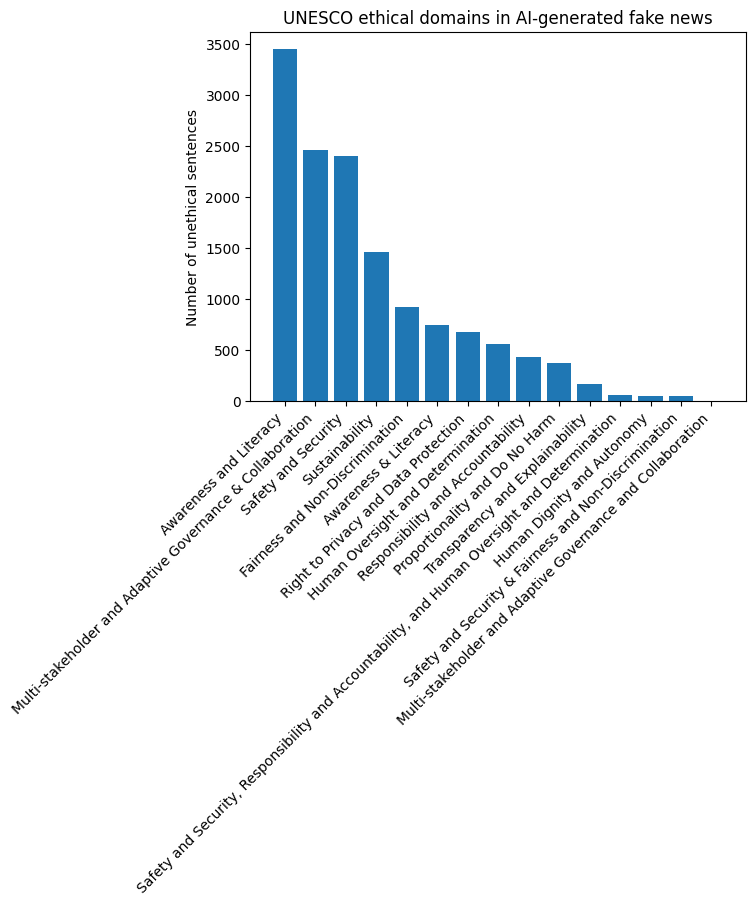

In [45]:
plt.bar(count_by_principle["unesco_principle"],
        count_by_principle["count_sentences"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of unethical sentences")
plt.title("UNESCO ethical domains in AI-generated fake news")
plt.tight_layout()
plt.show()
